In [1]:
# import data
import numpy as np
import pandas as pd
from graphdot import Graph
from graphdot.kernel.marginalized import MarginalizedGraphKernel
from graphdot.kernel.basekernel import TensorProduct
from graphdot.kernel.basekernel import SquareExponential
from graphdot.kernel.basekernel import KroneckerDelta
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [2]:
def evaluate(df,target,model,plot=True):
    y_pred = model.predict(df['graph'])
    if plot:
        plt.scatter(y_pred, df[target], s=2)
        plt.title(target + ' prediction')
        plt.plot([df[target].min(), df[target].max()],[df[target].min(), df[target].max()])
        plt.xlabel('simulation')
        plt.ylabel('prediction')
    # R2
    r2 = model.score(df['graph'],df[target])
    # MSE
    mse = mean_squared_error(y_pred, df[target])
    # variance explained
    ex_var = explained_variance_score(y_pred, df[target])
    print("R-square:%.3f\tMSE:%.3g\texplained_variance:%.3f" % (r2, mse, ex_var))
    return {'r2':r2, 'mse':mse, 'ex_var':ex_var}

In [3]:
import networkx as nx
from rdkit.Chem import MolFromSmiles
def smile2graph(smile):
    mol = MolFromSmiles(smile)

    if mol is not None:
        g = nx.Graph()

        for i, atom in enumerate(mol.GetAtoms()):
            g.add_node(i)
            #g.nodes[i]['symbol'] = atom.GetAtomicNum()
            g.nodes[i]['charge'] = atom.GetFormalCharge()
            g.nodes[i]['hcount'] = atom.GetTotalNumHs()
            g.nodes[i]['hybridization'] = atom.GetHybridization()
            g.nodes[i]['aromatic'] = atom.GetIsAromatic()
            g.nodes[i]['chiral'] = atom.GetChiralTag()

        for bond in mol.GetBonds():
            ij = (bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
            g.add_edge(*ij)
            g.edges[ij]['order'] = bond.GetBondType()
            g.edges[ij]['aromatic'] = bond.GetIsAromatic()
            g.edges[ij]['conjugated'] = bond.GetIsConjugated()
            g.edges[ij]['stereo'] = bond.GetStereo()
            g.edges[ij]['inring'] = bond.IsInRing()

        return Graph.from_networkx(g)
    else:
        return None

RDKit WARNING: [00:28:30] Enabling RDKit 2019.09.3 jupyter extensions


In [35]:
# defining kernel
class NormalizedKernel(MarginalizedGraphKernel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def __normalize(self, X, Y, R):
        if type(R) is tuple:
            d = np.diag(R[0])**-0.5
            K = np.diag(d).dot(R[0]).dot(np.diag(d))
            return (K, R[1])
        else:
            if Y is None:
                # square matrix
                d = np.diag(R)**-0.5
                K = np.diag(d).dot(R).dot(np.diag(d))
            else:
                # rectangular matrix, must have X and Y
                diag_X = super().diag(X)**-0.5
                diag_Y = super().diag(Y)**-0.5
                K = np.diag(diag_X).dot(R).dot(np.diag(diag_Y))
            return K
    def __call__(self, X, Y=None, *args, **kwargs):
        R = super().__call__(X, Y, *args, **kwargs)
        return self.__normalize(X, Y, R)

#initializing kernel
knode = TensorProduct(aromatic=KroneckerDelta(0.8),
                      charge=SquareExponential(1.0),
                      hcount=SquareExponential(1.0))

kedge = TensorProduct(order=KroneckerDelta(0.5))

normal_kernel = NormalizedKernel(knode, kedge, q=0.05)
kernel = MarginalizedGraphKernel(knode, kedge, q=0.05)

In [6]:
df = pd.read_csv('../data/result-ML-CH-critical.txt', sep=' ')
df['graph'] = [smile2graph(i) for i in df['SMILES']]

In [7]:
df.head()

,SMILES,tc,dc,graph
0,CCCC,414.5,0.2269,"<Graph(nodes={'!i': [0,1,2,3], 'aromatic': [Fa..."
1,CC(C)C,407.2,0.2291,"<Graph(nodes={'!i': [0,1,2,3], 'aromatic': [Fa..."
2,CCCCC,459.5,0.2320,"<Graph(nodes={'!i': [0,1,2,3,4], 'aromatic': [..."
3,CCC(C)C,455.0,0.2328,"<Graph(nodes={'!i': [0,1,2,3,4], 'aromatic': [..."
4,CC(C)(C)C,435.9,0.2366,"<Graph(nodes={'!i': [0,1,2,3,4], 'aromatic': [..."


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [21]:
scaler.fit_transform(np.array(df['dc']).reshape(-1,1)).std()

1.0

In [29]:
scaler.transform(df['tc'].values.reshape(-1,1)).flatten()

array([24882.03309324, 24443.55115234, 27585.00396185, ...,
       32071.93560374, 30864.60861576, 34744.87346269])

# einsum/broadcast test

In [30]:
# load some real data

In [65]:
df = pd.read_csv('../data/result-ML-All-critical.txt', sep=' ')
df['graph'] = df['SMILES'].apply(smile2graph)

In [67]:
len(df['graph'])

3617

In [82]:
%timeit a_kernel = kernel(list(df['graph']))

29.2 s ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [69]:
diag_d = np.diag(a_kernel) ** -0.5

In [71]:
#einsum
%timeit K = np.einsum("ij,i,j->ij", a_kernel, diag_d, diag_d)

18.8 ms ± 74.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [81]:
#broadcasting
%timeit K = diag_d * a_kernel * diag_d

21.2 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
a = np.array([[10,2],[4,9]])

In [76]:
d_a = np.diag(a) ** -0.5

In [77]:
a

array([[10,  2],
       [ 4,  9]])

In [80]:
%timeit d_a * a * d_a.reshape(-1,1)

array([[1.        , 0.21081851],
       [0.42163702, 1.        ]])

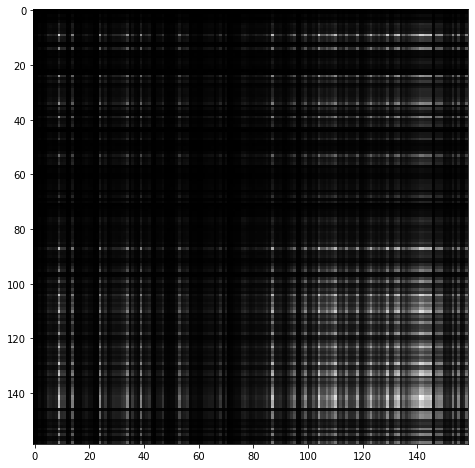

In [86]:
plt.figure(figsize=(8,8))
plt.imshow(K, cmap=plt.cm.gray)